In [1]:
import pandas as pd
import numpy as np

from sklearn import tree
from sklearn.model_selection import train_test_split, StratifiedKFold

from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import CategoricalNB

from preprocessing import preprocesamiento_GNB
from graficos_modelos import mostrar_reporte_clasificacion, graficar_auc_roc,graficar_matriz_confusion
from funciones_auxiliares import traer_datasets, traer_dataset_prediccion_final, separar_dataset, encontrar_hiperparametros_RGSCV,encontrar_hiperparametros_GSCV, mapear_target_binario

# Naive Bayes

### Obtención de los datos y preprocesamiento

In [2]:
df, df_sin_target, solo_target = traer_datasets()

X_train, X_test, y_train, y_test = separar_dataset(df_sin_target, solo_target)

y_train.set_index('id', inplace=True)
y_train = y_train.sort_values(by=['id'], ascending=True).copy()

y_test.set_index('id', inplace=True)
y_test = y_test.sort_values(by=['id'], ascending=True).copy()


Aplicamos preprocesamiento especifico para el modelo de naive bayes gaussiano

In [3]:
dataframes_procesados = preprocesamiento_GNB([X_train, X_test])
X_train = dataframes_procesados[0]
X_test = dataframes_procesados[1]

### Búsqueda de Hiperparámetros

Buscamos hiperparámetros GridSearch pues al ser un solo hiperparametro limitado a los valores seleccionados, no tendremos problemas de performance y será deterministico.

In [4]:
params = {'var_smoothing': [1e-9,1e-8,1e-7,1e-6,1e-5,1e-4]}
hiperparametros = encontrar_hiperparametros_GSCV(GaussianNB(), params=params, x_np=X_train.to_numpy(), y_np=y_train['llovieron_hamburguesas_al_dia_siguiente'].to_numpy())

suavizado_elegido = hiperparametros['var_smoothing']
print(f'Mejor suavizado: {suavizado_elegido}')

Mejor suavizado: 0.0001


### Entrenando el Modelo con CrossValidation

Procedemos a testear con kfolds, stratificados pues nuestro dataset es desbalanceado. Además, usamos los hiperparámetros encontrados previamente.

In [5]:
kf = StratifiedKFold(n_splits=5)
for fold_idx, (train_index, test_index) in enumerate(kf.split(X_train, y_train)):
    naive_bayes_gaussiano = GaussianNB(var_smoothing=suavizado_elegido)
    naive_bayes_gaussiano.fit(X_train.iloc[train_index], y_train.iloc[train_index])
    print ('Reporte para el FOLD ' + str(fold_idx))
    print(classification_report(y_train.iloc[test_index], naive_bayes_gaussiano.predict(X_train.iloc[test_index]), target_names=['No llueven hamburguesas al dia siguiente', 'Llueven hamburguesas al dia siguiente']))
    

C:\Users\Guillermo\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Reporte para el FOLD 0
                                          precision    recall  f1-score   support

No llueven hamburguesas al dia siguiente       0.88      0.88      0.88     15891
   Llueven hamburguesas al dia siguiente       0.59      0.59      0.59      4581

                                accuracy                           0.82     20472
                               macro avg       0.73      0.73      0.73     20472
                            weighted avg       0.82      0.82      0.82     20472

Reporte para el FOLD 1


C:\Users\Guillermo\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


                                          precision    recall  f1-score   support

No llueven hamburguesas al dia siguiente       0.90      0.77      0.83     15891
   Llueven hamburguesas al dia siguiente       0.47      0.70      0.56      4580

                                accuracy                           0.76     20471
                               macro avg       0.68      0.74      0.70     20471
                            weighted avg       0.80      0.76      0.77     20471

Reporte para el FOLD 2


C:\Users\Guillermo\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


                                          precision    recall  f1-score   support

No llueven hamburguesas al dia siguiente       0.91      0.77      0.83     15891
   Llueven hamburguesas al dia siguiente       0.48      0.73      0.58      4580

                                accuracy                           0.76     20471
                               macro avg       0.69      0.75      0.70     20471
                            weighted avg       0.81      0.76      0.78     20471

Reporte para el FOLD 3


C:\Users\Guillermo\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


                                          precision    recall  f1-score   support

No llueven hamburguesas al dia siguiente       0.89      0.87      0.88     15891
   Llueven hamburguesas al dia siguiente       0.58      0.64      0.61      4580

                                accuracy                           0.82     20471
                               macro avg       0.74      0.75      0.74     20471
                            weighted avg       0.82      0.82      0.82     20471

Reporte para el FOLD 4


C:\Users\Guillermo\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


                                          precision    recall  f1-score   support

No llueven hamburguesas al dia siguiente       0.89      0.90      0.89     15890
   Llueven hamburguesas al dia siguiente       0.63      0.60      0.61      4581

                                accuracy                           0.83     20471
                               macro avg       0.76      0.75      0.75     20471
                            weighted avg       0.83      0.83      0.83     20471



### Predicción del modelo sobre holdout

Una vez entrenado y validado el modelo con CrossValidation, viendo que las métricas resultantes fueron razonables y no dan indicio de overfit o mala división del dataset, pasaremos a probar el modelo en la partición Holdout. Para esto usaremos los mejores hiperparámetros hallados previamente en Training.

In [6]:
gnb_holdout = GaussianNB(var_smoothing=suavizado_elegido)
gnb_holdout.fit(X_train.to_numpy(), y_train.to_numpy())

C:\Users\Guillermo\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


GaussianNB(var_smoothing=0.0001)

In [7]:
mapeo_binario_v = np.vectorize(mapear_target_binario)
y_pred = gnb_holdout.predict(X_test.to_numpy())
y_pred_binario = mapeo_binario_v(y_pred)
y_pred_proba = gnb_holdout.predict_proba(X_test.to_numpy())[:, 1]
y_test_binario = y_test['llovieron_hamburguesas_al_dia_siguiente'].map({'si': 1, 'no': 0}).to_numpy()
print(classification_report(y_test['llovieron_hamburguesas_al_dia_siguiente'].to_numpy(), y_pred))

              precision    recall  f1-score   support

          no       0.89      0.84      0.87      8828
          si       0.54      0.65      0.59      2545

    accuracy                           0.80     11373
   macro avg       0.72      0.74      0.73     11373
weighted avg       0.81      0.80      0.80     11373



### Curva AUC ROC


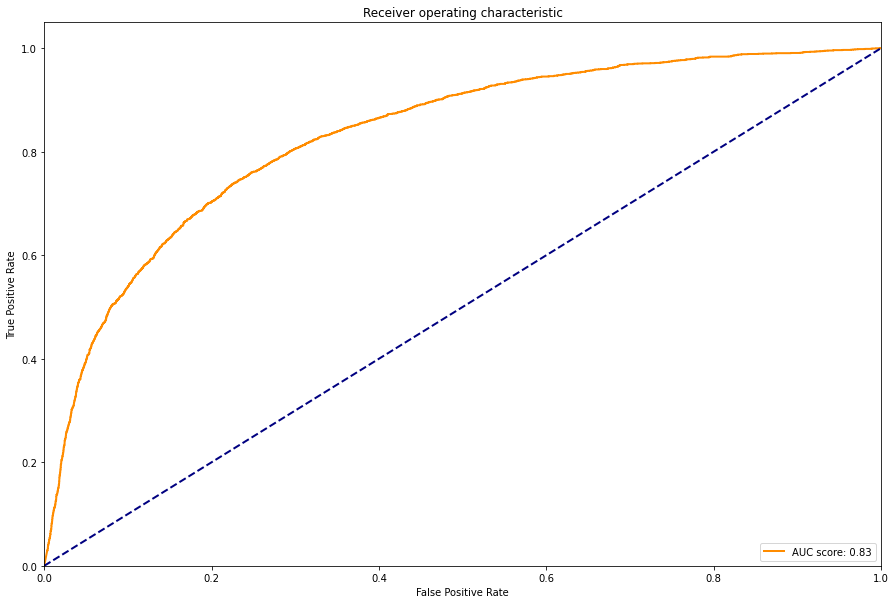

AUC-ROC para este modelo es: 0.8311036815348201


In [8]:
graficar_auc_roc(y_test_binario, y_pred_proba)

### Matriz de confusion

C:\Users\Guillermo\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=[0, 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


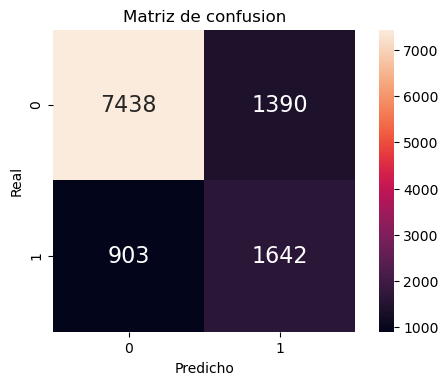

In [9]:
graficar_matriz_confusion(y_test_binario, y_pred_binario)

## Predicción con el dataset nuevo
A continuación, realizamos la predicción con el árbol sin expandir el dataset sobre el dataset de predicciones nuevo, y la escribimos al archivo 'NaiveBayes.csv'

In [10]:
from funciones_auxiliares import exportar_prediccion_final

df_prediccion_final = traer_dataset_prediccion_final()
ids = df_prediccion_final['id'].to_numpy()

df_prediccion_final = preprocesamiento_GNB([df_prediccion_final])[0]
predicciones = gnb_holdout.predict(df_prediccion_final.to_numpy())

exportar_prediccion_final(ids, predicciones, 'NaiveBayes')